# Timing Synchronization & Timing Error Detectors (TED)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from rfproto import filter, modulation, pi_filter, plot, sig_gen

In [ ]:
# simulate random binary input values
num_symbols  = 2400
sym_rate     = 1e6 # Baseband symbol rate
# Generate random QPSK symbols
rand_symbols = np.random.randint(0, 4, num_symbols)

L  = 8               # Upsample ratio (Samples per Symbol)
fs = L * sym_rate    # Output sample rate (Hz)

rolloff          = 0.25 # Alpha of RRC
num_filt_symbols = 6    # Symbol length of RRC matched filter

qpsk_tx_filtered_8x = sig_gen.gen_mod_signal(
    "QPSK",
    rand_symbols,
    fs,
    sym_rate,
    "RRC",
    rolloff,
    num_filt_symbols,
)

plot.IQ(qpsk_tx_filtered_8x, alpha=0.1)
plt.show()

In [ ]:
plot.spec_an(qpsk_tx_filtered_8x, fs=fs, fft_shift=True, show_SFDR=False, y_unit="dB", title=f"QPSK ({L}x SPS)")
plt.show()

In [ ]:
qpsk_tx_filtered = qpsk_tx_filtered_8x[::L//2] # arbitrary downsample by to bring input to 2SPS (no need to filter in this sim)
plot.spec_an(qpsk_tx_filtered, fs=fs, fft_shift=True, show_SFDR=False, y_unit="dB", title="QPSK (2x SPS)")
plt.show()

## Timing Error Detector (TED)



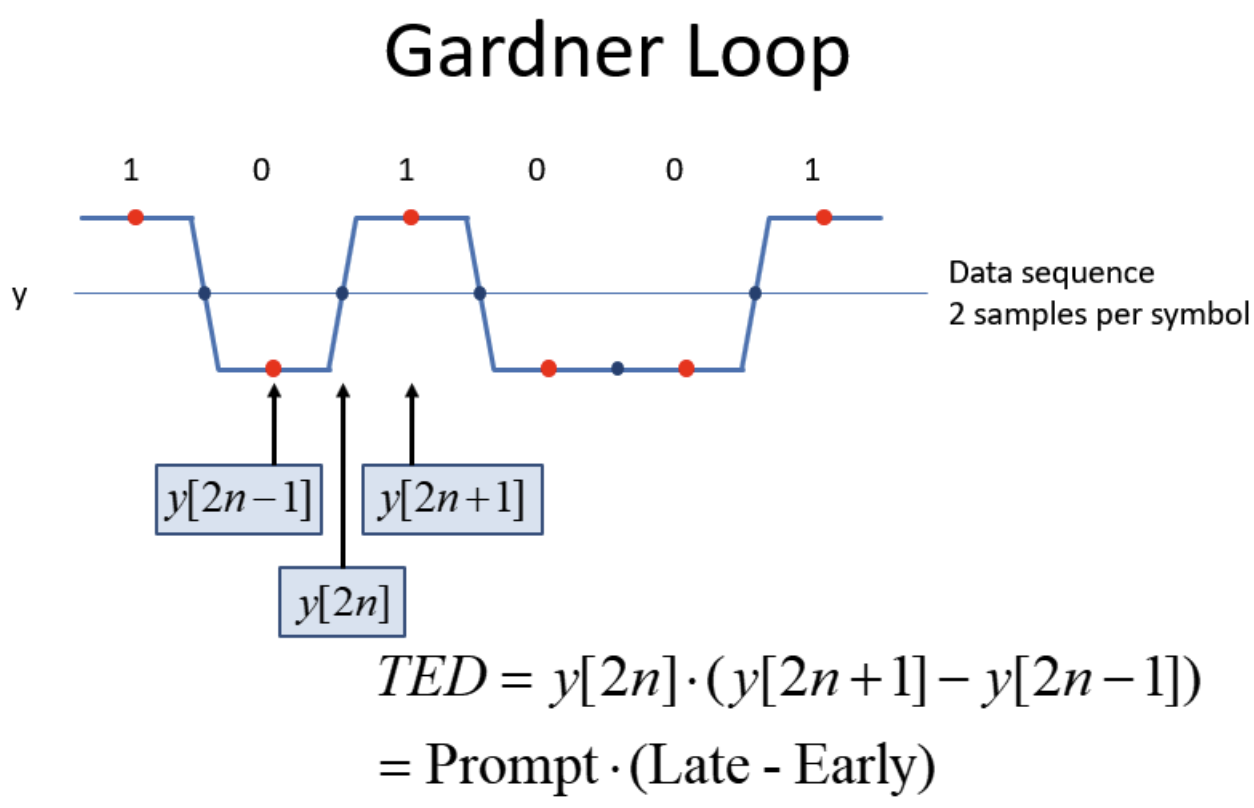
_[From this DSP StackExchange Post](https://dsp.stackexchange.com/a/75938)_

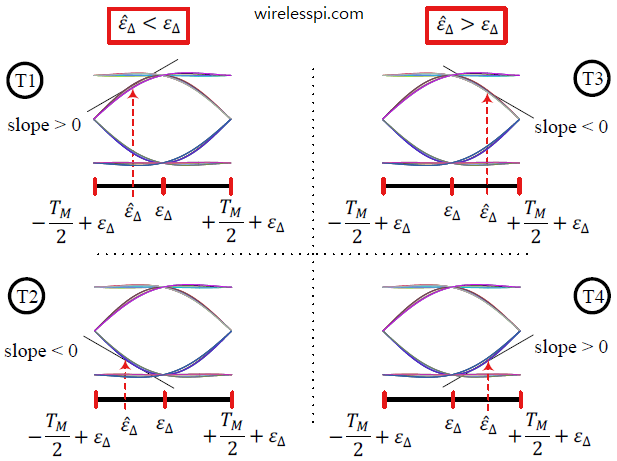

$$ \text{TED} = \mathbb{R}[\overline{y_{n}}(y_{n+1} - y_{n-1})] $$

In [ ]:
offset_2x = qpsk_tx_filtered_8x[3::L//2] # give timing offset to signal and downsample to 2x SPS
plot.samples(offset_2x[:100].real)
plt.show()

In [ ]:
late = offset_2x[2:]
prompt = offset_2x[1:-1]
early = offset_2x[:-2]

gardner_ted_err = np.real(np.conj(prompt[::2]) * (late - early)[::2])
plot.samples(gardner_ted_err[:100])
plt.show()

### References

* [Gardner Timing Error Detector: A Non-Data-Aided Version of Zero-Crossing Timing Error Detectors](https://wirelesspi.com/gardner-timing-error-detector-a-non-data-aided-version-of-zero-crossing-timing-error-detectors/)
* [Can we use Gardner timing error detector for multi level QAM or OFDM systems? - DSP Stack Exchange](https://dsp.stackexchange.com/questions/75927/can-we-use-gardner-timing-error-detector-for-multi-level-qam-or-ofdm-systems)
* [Symbol Synchronizer - Matlab Communications Toolbox](https://www.mathworks.com/help/comm/ref/comm.symbolsynchronizer-system-object.html)

## Polyphase Matched Filter for Timing Synchronization

From [the Multirate DSP page on Polyphase Filters](./Multirate_DSP.html#polyphase-filtering), we know that each leg of a polyphase filter is an _all-pass_ filter, with each leg providing a fractional amount of signal delay ($1/M$ samples of delay, where $M$ is the number of polyphase branches), spread equally over the duration of a symbol period. We can exploit this feature by coopting the commutator- traditionally used to cycle through each polyphase leg to perform the interpolation or decimation operation- to act as the delay selector in a timing error correction block!

This also leads to implementation optimizations, as only one FIR filter structure need be instantiated, with the commutator indexing a Look-Up Table (LUT) of each polyphase leg's filter coefficients at a given time.

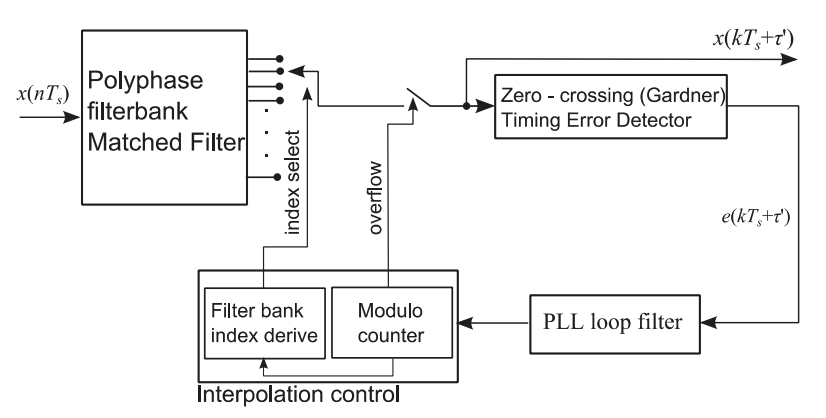
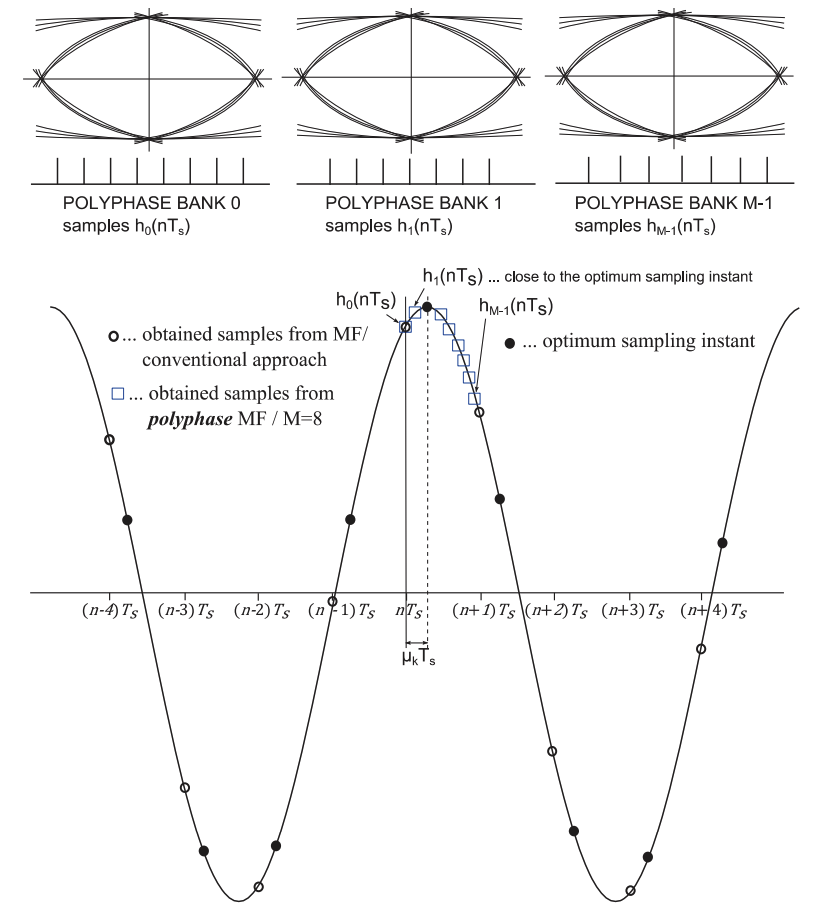

In a simple simulated system above, we were able to generate a QPSK signal (no frequency or phase offset present) at 2x Samples per Symbol (SPS). Below, we can see the ideal sampling location (minimal deviation from ideal constellation points in I/Q plane) can be found after matched filtering, selecting a fixed timing offset, and final downsampling to 1x SPS.

In [ ]:
# Pass transmitted waveform through same RRC (matched filter)
L = 2
rrc_coef = filter.RootRaisedCosine(L, 1, rolloff, 2 * num_filt_symbols * L + 1)
rx_shaped = signal.lfilter(rrc_coef, 1, qpsk_tx_filtered)

In [ ]:
# adjust for best EVM, similar to slicer
timing_offset = 4
plot.IQ(rx_shaped[timing_offset::L], alpha=0.4)
plt.show()

For the Polyphase Interpolation Filter case, we start by generating a similar Root Raised Cosine (RRC) filter as before, however the prototype filter is scaled by the number of polyphase filter legs- as done in other polyphase prototype designs- to maintain the correct matched filter response.

In [ ]:
# The number of taps of this filter is based on how long you expect the channel to be; that is, 
# how many symbols do you want to combine to get the current symbols energy back, usually 5 to 10+
taps = 2 * num_filt_symbols * L + 1
# With 32 filters, you get a good enough resolution in the phase to produce very small, almost 
# unnoticeable, ISI. Going to 64 filters can reduce this more, but after that there is very little 
# gain for the extra complexity. Total prototype filter taps = taps * num_filters, since we're 
# instantiating segments of these taps into the filterbanks in such a way that each bank now 
# represents the filter at different phases, equally spaced at 2pi/N, where N is the number of filters.
num_filters = 31
polyphase_rrc_coef = filter.RootRaisedCosine(num_filters * L, 1, rolloff, taps * num_filters)

plot.filter_response(polyphase_rrc_coef, title=f"{num_filters} x {taps}-tap RRC Polyphase Prototype Filter")
plot.plt.show()

In [ ]:
h_poly_rrc = polyphase_rrc_coef.reshape(len(polyphase_rrc_coef)//num_filters, num_filters).T
print(np.shape(h_poly_rrc))

We can then simulate sweeping of the commutator and filtering input samples across each static leg of the RRC polyphase filter to show the eye opening and closing based on timing correction:

In [ ]:
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()
line, = ax.plot([], [], ".", alpha=0.3)
plt.axvline(x=0, color="orange")
plt.axhline(y=0, color="orange")
plt.margins(x=0)
plt.grid(True, linestyle="--")
plt.minorticks_on()
plt.tick_params(labelsize=8)
plt.xlabel("In-Phase (I)", fontsize=12)
plt.ylabel("Quadrature (Q)", fontsize=12)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xlim([-0.02, 0.02])
ax.set_ylim([-0.02, 0.02])

def update_plot(frame):
    poly_match_out = signal.lfilter(h_poly_rrc[frame], 1, qpsk_tx_filtered)
    # NOTE: perform final decimation-by-2 here to bring output to 1x SPS
    line.set_xdata(np.real(poly_match_out[::2]))
    line.set_ydata(np.imag(poly_match_out[::2]))
    ax.set_title(f"Polyphase RRC Leg: {frame}")
    return line,

anim = FuncAnimation(fig, update_plot, frames=num_filters, interval=100, blit=True, repeat=True)
anim.save('iq_polyphase_timing.gif', writer='pillow')
plt.close()

<img src="iq_polyphase_timing.gif" width="750" align="center">

In [ ]:
in_delay = np.zeros(taps) * 1j*np.zeros(taps)
early = 0.0 * 1j*0.0
prompt = 0.0 * 1j*0.0
late = 0.0 * 1j*0.0
filt_out = []
ted_out = []
pi_out = []
comm_idx = 0
loop_filt = pi_filter.PiFilter(5e-4, 1e-6)
loop_filt.accumulator = 15

for idx, x in enumerate(offset_2x):
    # First shift in sample into delay line
    for i in reversed(range(taps)):
        if i < taps - 1:
            in_delay[i+1] = in_delay[i]
    in_delay[0] = x

    # Next multiply-accumulate the discrete convolution of delay line of input
    # samples with the current polyphase filter leg coefficients
    mac = 0.0 * 1j*0.0
    for i in range(taps):
        mac += in_delay[i] * h_poly_rrc[28][i]

    # Shift in samples at 2x SPS rate to TED early/prompt/late registers
    late = prompt
    prompt = early
    early = mac
    
    # Perform downsample by 2 and operate TED at output rate
    if idx % 2 == 0:
        filt_out.append(mac)
    
        # Perform TED error calculation
        diff = late - early
        err_cmplx = prompt * np.conj(diff)
        err = np.real(err_cmplx) + np.imag(err_cmplx)
        ted_out.append(err)
    
        # Loop filter
        pi_tmp = loop_filt.Step(err)
        pi_out.append(pi_tmp)
        comm_idx = round(pi_tmp) % num_filters

plot.IQ(filt_out, alpha=0.4)
plt.show()

plot.samples(ted_out)
plt.show()

plot.samples(pi_out)
plt.show()

plot.samples(np.round(pi_out) % num_filters)
plt.show()

### References
* [Symbol Synchronizer - Liquid SDR](https://liquidsdr.org/doc/symsync/)
* [Polyphase Clock Sync - GNU Radio](https://wiki.gnuradio.org/index.php/Polyphase_Clock_Sync)
* [Symbol Synchronization for SDR Using a Polyphase Filterbank Based on an FPGA](https://www.radioeng.cz/fulltexts/2015/15_03_0772_0782.pdf)
* [Simulating the TED gain for a polyphase matched filter](https://destevez.net/2020/02/simulating-the-ted-gain-for-a-polyphase-matched-filter/)

## References

* [Carrier and Timing Synchronization in Digital Modems - fred harris](https://s3.amazonaws.com/embeddedrelated/user/124841/synchronization_qualcomm_2018_4_11449.pdf)
* [On the Frequency Carrier Offset and Symbol Timing Estimation for CCSDS 131.2-B-1 High Data-Rate Telemetry Receivers](https://www.mdpi.com/1424-8220/21/9/2915)